
🚀 訓練模型：batch_size=16, epochs=50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
⏳ 訓練時間: 3.85 秒, MAE: 2.932, RMSE: 4.707, MAPE: 14.13%

🚀 訓練模型：batch_size=16, epochs=100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
⏳ 訓練時間: 6.91 秒, MAE: 2.643, RMSE: 4.187, MAPE: 13.48%

🚀 訓練模型：batch_size=16, epochs=150
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E338F5B1A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.or

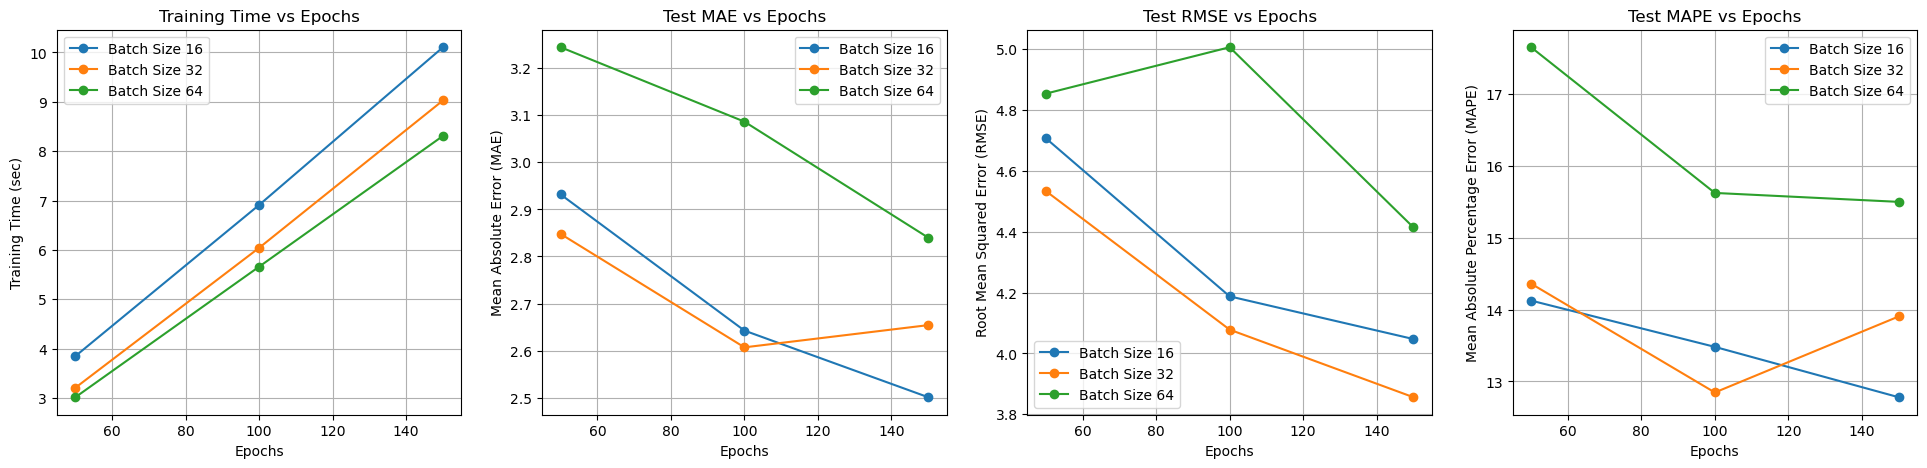

In [1]:
# 匯入必要的函式庫
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop

# 1️⃣ 載入 Boston Housing 數據集
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 2️⃣ 數據標準化（Z-score normalization）
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# 3️⃣ 定義 RMSE 和 MAPE 計算函數
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 4️⃣ 建立深度神經網路
def build_model():
    model = Sequential([
        Input(shape=(train_data.shape[1],)),  # 🔹 使用 Input() 定義輸入層
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # 輸出層（預測房價）
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])
    return model

# 5️⃣ 設定不同的 batch size & epoch
batch_sizes = [16, 32, 64]
epochs_list = [50, 100, 150]
results_dict = {}

# 6️⃣ 訓練不同組合的模型，記錄訓練時間 & 預測誤差
for batch_size in batch_sizes:
    for epochs in epochs_list:
        print(f"\n🚀 訓練模型：batch_size={batch_size}, epochs={epochs}")
        model = build_model()

        # 記錄訓練時間
        start_time = time.time()

        # 訓練模型
        history = model.fit(train_data, train_targets, 
                            epochs=epochs, batch_size=batch_size, 
                            validation_data=(test_data, test_targets),
                            verbose=0)

        end_time = time.time()
        training_time = end_time - start_time  # 訓練時間

        # 取得測試集預測結果
        predictions = model.predict(test_data).flatten()

        # 計算 MAE、RMSE、MAPE
        test_mae = np.mean(np.abs(test_targets - predictions))  # MAE
        test_rmse = rmse(test_targets, predictions)  # RMSE
        test_mape = mape(test_targets, predictions)  # MAPE

        # 儲存結果
        results_dict[(batch_size, epochs)] = {
            "Training Time (sec)": training_time,
            "MAE": test_mae,
            "RMSE": test_rmse,
            "MAPE": test_mape
        }

        print(f"⏳ 訓練時間: {training_time:.2f} 秒, MAE: {test_mae:.3f}, RMSE: {test_rmse:.3f}, MAPE: {test_mape:.2f}%")

# 7️⃣ 視覺化分析不同 `batch size` & `epoch` 的影響
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# 📌 訓練時間
for batch_size in batch_sizes:
    times = [results_dict[(batch_size, epochs)]['Training Time (sec)'] for epochs in epochs_list]
    axes[0].plot(epochs_list, times, marker='o', label=f'Batch Size {batch_size}')

axes[0].set_title("Training Time vs Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Training Time (sec)")
axes[0].legend()
axes[0].grid()

# 📌 MAE
for batch_size in batch_sizes:
    mae_values = [results_dict[(batch_size, epochs)]['MAE'] for epochs in epochs_list]
    axes[1].plot(epochs_list, mae_values, marker='o', label=f'Batch Size {batch_size}')

axes[1].set_title("Test MAE vs Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Mean Absolute Error (MAE)")
axes[1].legend()
axes[1].grid()

# 📌 RMSE
for batch_size in batch_sizes:
    rmse_values = [results_dict[(batch_size, epochs)]['RMSE'] for epochs in epochs_list]
    axes[2].plot(epochs_list, rmse_values, marker='o', label=f'Batch Size {batch_size}')

axes[2].set_title("Test RMSE vs Epochs")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Root Mean Squared Error (RMSE)")
axes[2].legend()
axes[2].grid()

# 📌 MAPE
for batch_size in batch_sizes:
    mape_values = [results_dict[(batch_size, epochs)]['MAPE'] for epochs in epochs_list]
    axes[3].plot(epochs_list, mape_values, marker='o', label=f'Batch Size {batch_size}')

axes[3].set_title("Test MAPE vs Epochs")
axes[3].set_xlabel("Epochs")
axes[3].set_ylabel("Mean Absolute Percentage Error (MAPE)")
axes[3].legend()
axes[3].grid()

plt.show()
